# Error calculus of calibrated thermocouples

# Imports

In [29]:
import numpy as np
from utilities.data.lvm import lvm_to_df
# Données d'étalonnage
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

from tqdm import tqdm

## Get data

<Axes: >

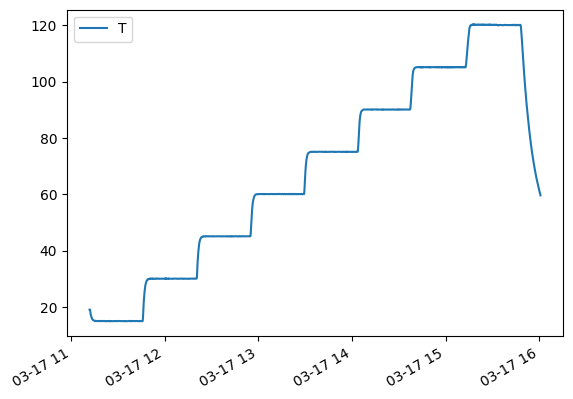

In [30]:
#Exexmple données réelles
df = lvm_to_df(r'C:\Users\yberton\OneDrive - INSA Lyon\Expérimental\Acquisition\Etalonnage\E_in_imm\17_03_2025.lvm')
df_et = pd.DataFrame({"T" : df['202 - E_in_imm [°C]']})
df_et.plot()


# Measures treatments

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""\
The idea here is to get rid of the transition period in between two calibration points \
In order to do so, a standart deviation calculus is realized for each temperature value over the four last values \
If it is under a certain value to be defined by the user, then the measure is erased

Let's make sure that the steady state was reached !


In [31]:

#Get the serie time step
dt = df_et.index[1] - df_et.index[0]
dt = dt.seconds + dt.microseconds*10e-6 + dt.nanoseconds*10e-9 # [seconds]
t_step = 60*5 # Time step for steady state conditions in the rolling(std) method of df [seconds]


In [32]:

# Get the temperature used for the calibration from user
# Temperatures used for the calibration
LT = [15,30,45,60,75,90,105,120]

## Cut the data to surrender the temperatures of reference

In [33]:

# We find in between temp in order to split the dataframe in several ones for a giver reference temmperature
LT_to_sort = [(LT[i] + LT[i+1])/2 for i in range(0, 7)]
df_to_sort = df_et.copy()

Ldfs = []  # Initializing list of dataframe
for Tmax in LT_to_sort:
    df_left = df_to_sort[df_to_sort.iloc[:, 0] < Tmax]  # Cut data to add to the dataframe list
    df_to_sort = df_to_sort[df_to_sort.iloc[:, 0] >= Tmax]  # Cut this data from df
    Ldfs.append(df_left)  # Append the cut dataframe to the list of dataframe
# Finally, append the remaing data in df as the last dataframe of the list
Ldfs.append(df_to_sort)

In [34]:
df_et

,T
2025-03-17 11:12:00.912390,19.073353
2025-03-17 11:12:10.912390,19.066837
2025-03-17 11:12:20.912390,19.092676
2025-03-17 11:12:30.912390,18.185490
2025-03-17 11:12:40.912390,17.554129
...,...
2025-03-17 16:00:00.912390,61.023769
2025-03-17 16:00:10.912390,60.752750
2025-03-17 16:00:20.912390,60.323978
2025-03-17 16:00:30.912390,60.080757


## Calculate the average temperature for steady state data

In [35]:

Ldf_treated = []  # Initialization of treated list of dataframes
LTmean = []  # Initialization of Tmean array

std_lim = 0.001
std_buff = std_lim
Lstd= []
for i in tqdm(range(len(Ldfs))):  # Going through all the dataframes for each temperature test
    df = Ldfs[i]  # Get the dataframe

    # Let's make sure that the steady state was reached
    # Get a standart deviation for a period set by the user through t_step
    df_std = df.rolling(round(t_step/dt)).std()
    cols = [col for col in df_std.columns]  # get columns' names in a array
    # Create new cols names
    new_cols = [col + '_std' for col in df_std.columns]

    # Add the std values to the first dataframe
    for i in tqdm(range(0, len(new_cols))):
        df[new_cols[i]] = df_std[cols[i]]

    # Delete the lines where std < std_lim
    for i in tqdm(range(int(len(df.columns)/2), int(len(df.columns)))):
        std_buff = std_lim
        df_buff = df[df.iloc[:, i] < std_lim]
        while len(df_buff) <= 20:
            std_buff += 0.01
            df_buff = df[df.iloc[:, i] < std_buff] 
            if std_buff > 1:
                break
        df = df_buff.copy()
        Lstd.append(std_buff)
            
    Tmean = []
    # Get the average value
    for i in tqdm(range(0, int(len(df.columns)/2))):
        Tmean.append(df.iloc[:, i].mean())

    # Add the treated dataframe to a list
    Ldf_treated.append(df)

    # Add the mean temperature to a list
    LTmean.append(Tmean)

100%|██████████| 8/8 [00:00<00:00, 100.45it/s]


# Calibration of the thermocouple : f = a.x + b

### Calibration data

In [36]:
#####ETALONNAGE#####
# Exemple de données d'étalonnage (en K)
x = np.array(LT)  # Températures de référence
yik = [ser.iloc[:,0].to_numpy() for ser in Ldf_treated]
n = [len(yi) for yi in yik]
m = len(x) # Ici = 8
N = sum(n)
yi = np.array(LTmean)  # Températures mesurées par le thermocouple
y_bar = sum([sum(j) for j in yik])/N 
x_bar = sum([n[i]*x[i] for i in range(m)])/N

### Linear regression

In [37]:
# Régression linéaire
a, b = np.polyfit(y=yi, x=x, deg=1)
y_chap = a*yi + b 


### si² calculation

In [53]:
Lsi2 = []
for i in range(0,m):
    si2 = 0
    for k in range(0,n[i]):
        si2 += (1/(n[i] - 1) * (yik[i][k] - np.mean(yik[i]))**2)
    Lsi2.append(si2)
Lsi2 = np.array(Lsi2)

### gi calculation

It is necessary to calculate the gi values since the previous Si are not constants. A ponderation is necessary.

In [54]:
K = 100  #POURQUOIIII ? PARCE QUE
gi = K/Lsi2


### sl² calculation

In [38]:
sl2 = 0
for i in range(0,m):
    for k in range(0,n[i]):
        sl2 += (yik[i][k] - y_chap[i])**2
sl2 = sl2/(N-2)

In [39]:
sa2 = sl2*( (1/N) + (x_bar**2)/sum(n[i]*[(x[i] - x_bar)**2 for i in range(m)]))
print(sa2)

[8.05607132e-05]


### Calcul de Sa²

In [40]:
sa2 = sl2*( (1/N) + (x_bar**2)/sum(n[i]*[(x[i] - x_bar)**2 for i in range(m)]))

### Calcul de Sb²

In [41]:
sb2 = sl2/(sum(n[i]*[(x[i] - x_bar)**2 for i in range(m)]))

## Errors calculus : $s(x_{0})^{2} = s_{1}(x_{0})^{2} + s_{2}(x_{0})^{2}$

## Get different data than the one for calibration

<Axes: >

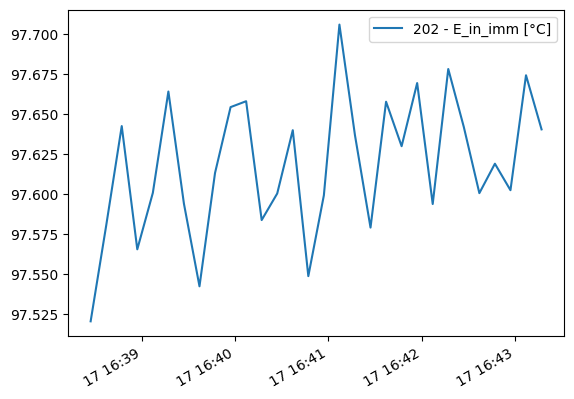

In [42]:
#####BASE DE DONNEES INDEPENDANTE ETALONNAGE#####
T_test_mes_series = lvm_to_df(r".\exemples\PPh_359.lvm").filter(['202 - E_in_imm [°C]'],axis=1).to_numpy() # Températures de test - essai en RP
lvm_to_df(r".\exemples\PPh_359.lvm").filter(['202 - E_in_imm [°C]'],axis=1).plot()

## $s_{1}(x_{0})$ calculus

In [43]:
x_0 = T_test_mes_series
y_0_chap = a*x_0 + b
x_0_bar = np.mean(x_0)

s12 = sl2*( (1/N) + (x_0_bar-x_bar)**2/(sum([n[i]*(x[i]-x_bar)**2 for i in range(len(x))])))/(a**2)
print(s12)

[2.48127816e-05]


## $s_{2}(x_{0})$ calculus

[53, 119, 92, 64, 71, 21, 140, 62]